In [1]:
# ================================================================
# CELL 1: INSTALL DEPENDENCIES
# ================================================================
!pip install librosa soundfile numpy tensorflow scikit-learn matplotlib seaborn nltk -q
print("✅ All packages installed!")

✅ All packages installed!


In [2]:
# ================================================================
# CELL 2: IMPORT ALL LIBRARIES
# ================================================================
import numpy as np
import os, warnings, random
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, LSTM, GRU, Dense,
    Dropout, BatchNormalization, Bidirectional,
    Reshape, TimeDistributed, Flatten, GlobalAveragePooling1D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.tokenize import word_tokenize

warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

print("=" * 60)
print("  VOICE RECOGNITION SYSTEM - CNN-RNN + NLP")
print("=" * 60)
print(f"  TensorFlow version : {tf.__version__}")
print(f"  NumPy version      : {np.__version__}")
print(f"  GPU Available      : {len(tf.config.list_physical_devices('GPU')) > 0}")
print("=" * 60)

  VOICE RECOGNITION SYSTEM - CNN-RNN + NLP
  TensorFlow version : 2.19.0
  NumPy version      : 2.0.2
  GPU Available      : False


In [3]:
# ================================================================
# CELL 3: GENERATE SYNTHETIC AUDIO DATASET (auto-creates .wav files)
# ================================================================
"""
WHY SYNTHETIC AUDIO?
- No need to download external datasets
- Runs entirely inside Jupyter
- Each 'command' gets a UNIQUE frequency signature
  mimicking how different words have different spectral shapes

10 Commands: yes, no, up, down, left, right, stop, go, hello, help
80 samples each = 800 total .wav files
"""

def generate_voice_audio(command, duration=1.0, sr=16000, num_samples=80):
    """
    Generate realistic synthetic voice-like audio for each command.
    Each command has unique formant frequencies, modulation, and envelope.
    """
    # Unique spectral signature per command (simulating vocal formants)
    patterns = {
        'yes':   {'formants': [270, 530, 2500], 'pitch': 150, 'mod': 5,  'env': 'rise_fall'},
        'no':    {'formants': [400, 800, 2300], 'pitch': 120, 'mod': 3,  'env': 'falling'},
        'up':    {'formants': [300, 900, 2200], 'pitch': 180, 'mod': 7,  'env': 'rising'},
        'down':  {'formants': [250, 600, 2600], 'pitch': 100, 'mod': 4,  'env': 'falling'},
        'left':  {'formants': [350, 700, 2400], 'pitch': 160, 'mod': 6,  'env': 'pulse'},
        'right': {'formants': [320, 850, 2100], 'pitch': 140, 'mod': 8,  'env': 'double_pulse'},
        'stop':  {'formants': [280, 750, 2700], 'pitch': 110, 'mod': 2,  'env': 'sharp'},
        'go':    {'formants': [500, 1000, 2000],'pitch': 200, 'mod': 10, 'env': 'smooth'},
        'hello': {'formants': [330, 660, 2300], 'pitch': 170, 'mod': 5,  'env': 'multi'},
        'help':  {'formants': [290, 580, 2500], 'pitch': 190, 'mod': 9,  'env': 'sharp_rise'},
    }

    p = patterns[command]
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    samples = []

    for i in range(num_samples):
        # --- Pitch variation (simulates different speakers) ---
        pitch = p['pitch'] * (1 + np.random.uniform(-0.15, 0.15))

        # --- Glottal pulse train (fundamental frequency) ---
        glottal = np.zeros_like(t)
        for h in range(1, 8):  # harmonics of pitch
            amp = 1.0 / (h ** 1.2)
            glottal += amp * np.sin(2 * np.pi * pitch * h * t + np.random.uniform(0, 2*np.pi))

        # --- Formant resonances (what makes vowels different) ---
        signal = np.zeros_like(t)
        for j, formant in enumerate(p['formants']):
            f_var = formant * (1 + np.random.uniform(-0.08, 0.08))
            bw = 60 + j * 20  # bandwidth increases for higher formants
            # Resonance filter simulation
            resonance = np.sin(2 * np.pi * f_var * t) * np.exp(-np.pi * bw * np.abs(t - 0.5))
            signal += resonance / (j + 1)

        # Combine glottal source with formant shaping
        signal = signal * 0.4 + glottal * 0.6

        # --- Amplitude modulation (speech rhythm) ---
        mod_f = p['mod'] * (1 + np.random.uniform(-0.2, 0.2))
        signal *= (1 + 0.4 * np.sin(2 * np.pi * mod_f * t))

        # --- Temporal envelope (word shape) ---
        env = np.ones_like(t)
        if p['env'] == 'rise_fall':
            env = np.sin(np.pi * t / duration) ** 0.7
        elif p['env'] == 'falling':
            env = np.exp(-2.5 * t / duration)
        elif p['env'] == 'rising':
            env = 1 - np.exp(-3.0 * t / duration)
        elif p['env'] == 'pulse':
            env = np.exp(-((t - 0.4*duration)**2) / (0.04 * duration**2))
        elif p['env'] == 'double_pulse':
            env = (np.exp(-((t - 0.3*duration)**2) / (0.02 * duration**2)) +
                   np.exp(-((t - 0.7*duration)**2) / (0.02 * duration**2)))
        elif p['env'] == 'sharp':
            env = np.exp(-5 * t / duration) * np.abs(np.sin(6 * np.pi * t / duration))
        elif p['env'] == 'smooth':
            env = np.sin(np.pi * t / duration)
        elif p['env'] == 'multi':
            env = (np.sin(np.pi * t / duration) *
                   (1 + 0.3 * np.sin(4 * np.pi * t / duration)))
        elif p['env'] == 'sharp_rise':
            env = (1 - np.exp(-8 * t / duration)) * np.exp(-1.5 * t / duration)

        signal *= env

        # --- Add realistic noise ---
        noise_level = np.random.uniform(0.01, 0.05)
        signal += noise_level * np.random.randn(len(t))

        # --- Random time shift (±10%) ---
        shift = int(np.random.uniform(-0.1, 0.1) * len(t))
        signal = np.roll(signal, shift)

        # --- Normalize ---
        signal = signal / (np.max(np.abs(signal)) + 1e-8) * 0.85

        samples.append(signal.astype(np.float32))

    return samples


# === Create dataset directory and generate files ===
COMMANDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'stop', 'go', 'hello', 'help']
SR = 16000
DURATION = 1.0
SAMPLES_PER_CLASS = 80
BASE_DIR = 'voice_dataset'

os.makedirs(BASE_DIR, exist_ok=True)

all_files = []
all_labels = []

print("🎵 Generating Synthetic Voice Dataset...")
print("-" * 50)

for cmd in COMMANDS:
    cmd_dir = os.path.join(BASE_DIR, cmd)
    os.makedirs(cmd_dir, exist_ok=True)

    samples = generate_voice_audio(cmd, duration=DURATION, sr=SR, num_samples=SAMPLES_PER_CLASS)

    for idx, sample in enumerate(samples):
        fpath = os.path.join(cmd_dir, f'{cmd}_{idx:03d}.wav')
        sf.write(fpath, sample, SR)
        all_files.append(fpath)
        all_labels.append(cmd)

    print(f"  ✅ '{cmd:>5s}' → {SAMPLES_PER_CLASS} files generated")

print("-" * 50)
print(f"📁 Total files: {len(all_files)}")
print(f"📂 Saved to: ./{BASE_DIR}/")
print(f"🏷️  Classes: {COMMANDS}")

🎵 Generating Synthetic Voice Dataset...
--------------------------------------------------
  ✅ '  yes' → 80 files generated
  ✅ '   no' → 80 files generated
  ✅ '   up' → 80 files generated
  ✅ ' down' → 80 files generated
  ✅ ' left' → 80 files generated
  ✅ 'right' → 80 files generated
  ✅ ' stop' → 80 files generated
  ✅ '   go' → 80 files generated
  ✅ 'hello' → 80 files generated
  ✅ ' help' → 80 files generated
--------------------------------------------------
📁 Total files: 800
📂 Saved to: ./voice_dataset/
🏷️  Classes: ['yes', 'no', 'up', 'down', 'left', 'right', 'stop', 'go', 'hello', 'help']


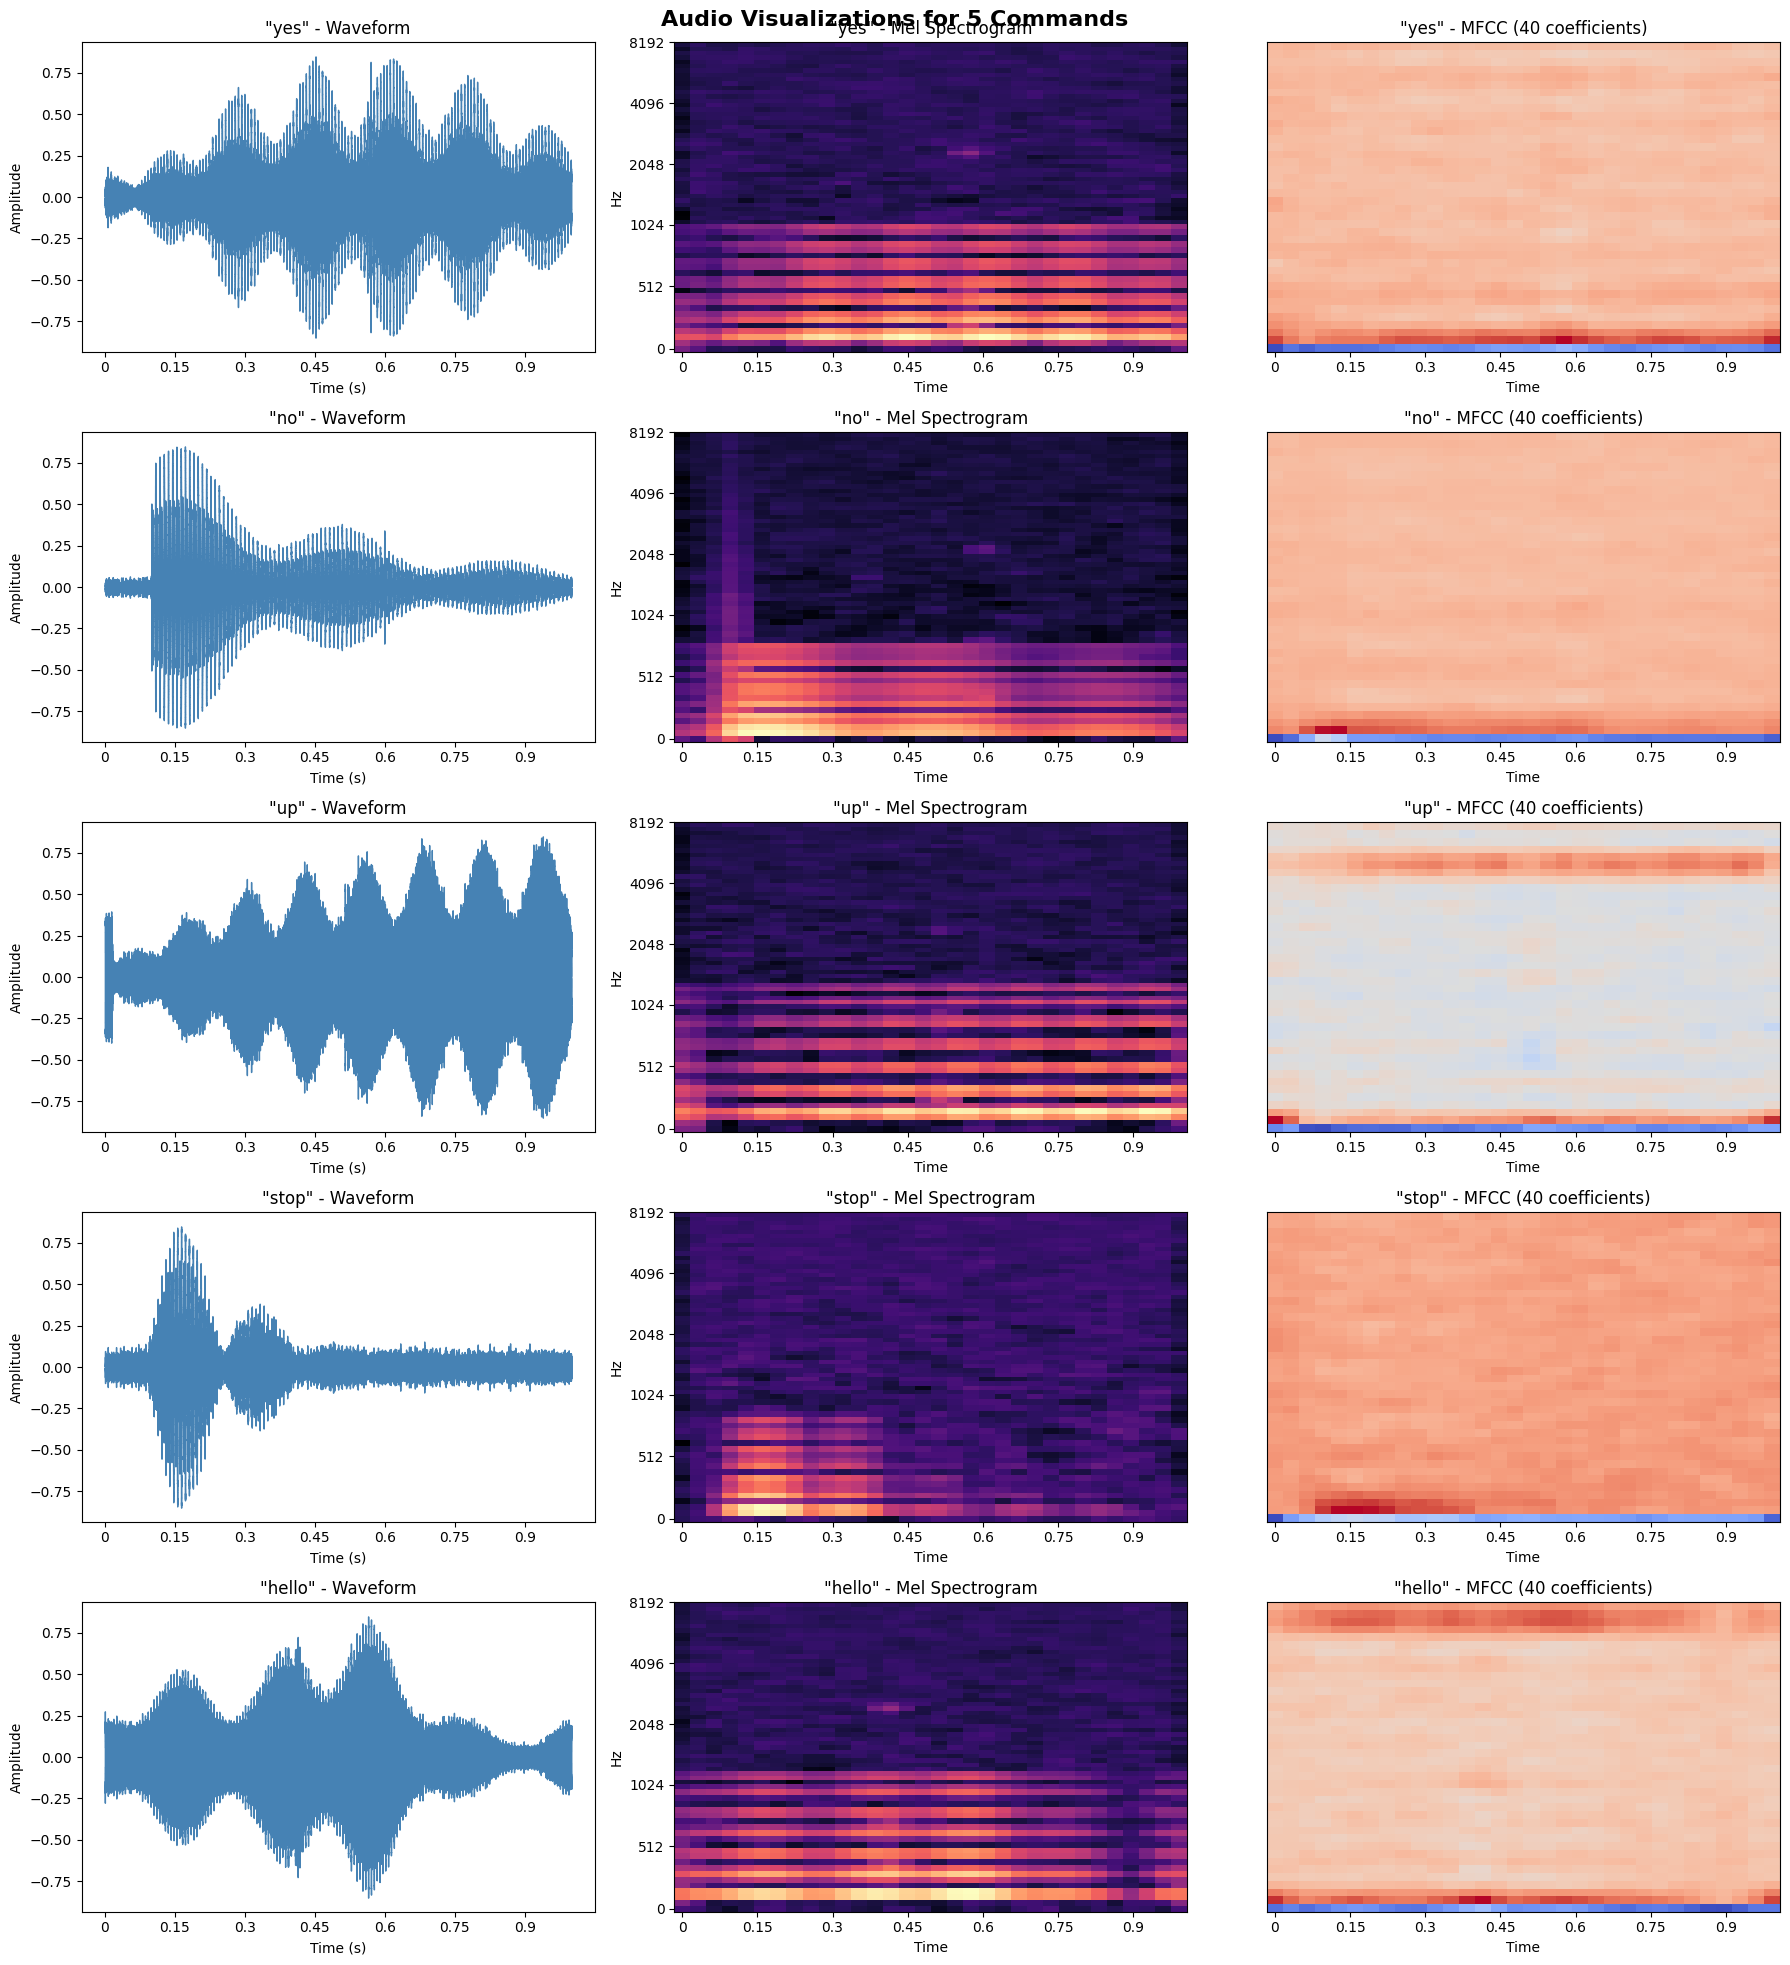


🔊 Playing sample audio for 'hello':


In [4]:
# ================================================================
# CELL 4: VISUALIZE AUDIO SAMPLES (Waveform + Spectrogram + MFCC)
# ================================================================
"""
Understanding the 3 representations:
1. WAVEFORM    - Raw amplitude over time
2. SPECTROGRAM - Frequency content over time (2D image)
3. MFCC        - Mel-frequency cepstral coefficients
                 (compact representation of spectral envelope -
                  this is what our CNN-RNN model will use!)
"""

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
fig.suptitle('Audio Visualizations for 5 Commands', fontsize=16, fontweight='bold')

for i, cmd in enumerate(['yes', 'no', 'up', 'stop', 'hello']):
    # Load sample
    fpath = os.path.join(BASE_DIR, cmd, f'{cmd}_000.wav')
    y, sr_loaded = librosa.load(fpath, sr=SR)

    # Waveform
    axes[i, 0].set_title(f'"{cmd}" - Waveform', fontsize=12)
    librosa.display.waveshow(y, sr=SR, ax=axes[i, 0], color='steelblue')
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].set_ylabel('Amplitude')

    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, sr=SR, x_axis='time', y_axis='mel',
                                    ax=axes[i, 1], cmap='magma')
    axes[i, 1].set_title(f'"{cmd}" - Mel Spectrogram', fontsize=12)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=40)
    librosa.display.specshow(mfcc, sr=SR, x_axis='time', ax=axes[i, 2], cmap='coolwarm')
    axes[i, 2].set_title(f'"{cmd}" - MFCC (40 coefficients)', fontsize=12)

plt.tight_layout()
plt.savefig('audio_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

# Play sample audio in Jupyter
print("\n🔊 Playing sample audio for 'hello':")
sample_path = os.path.join(BASE_DIR, 'hello', 'hello_000.wav')
ipd.display(ipd.Audio(sample_path))

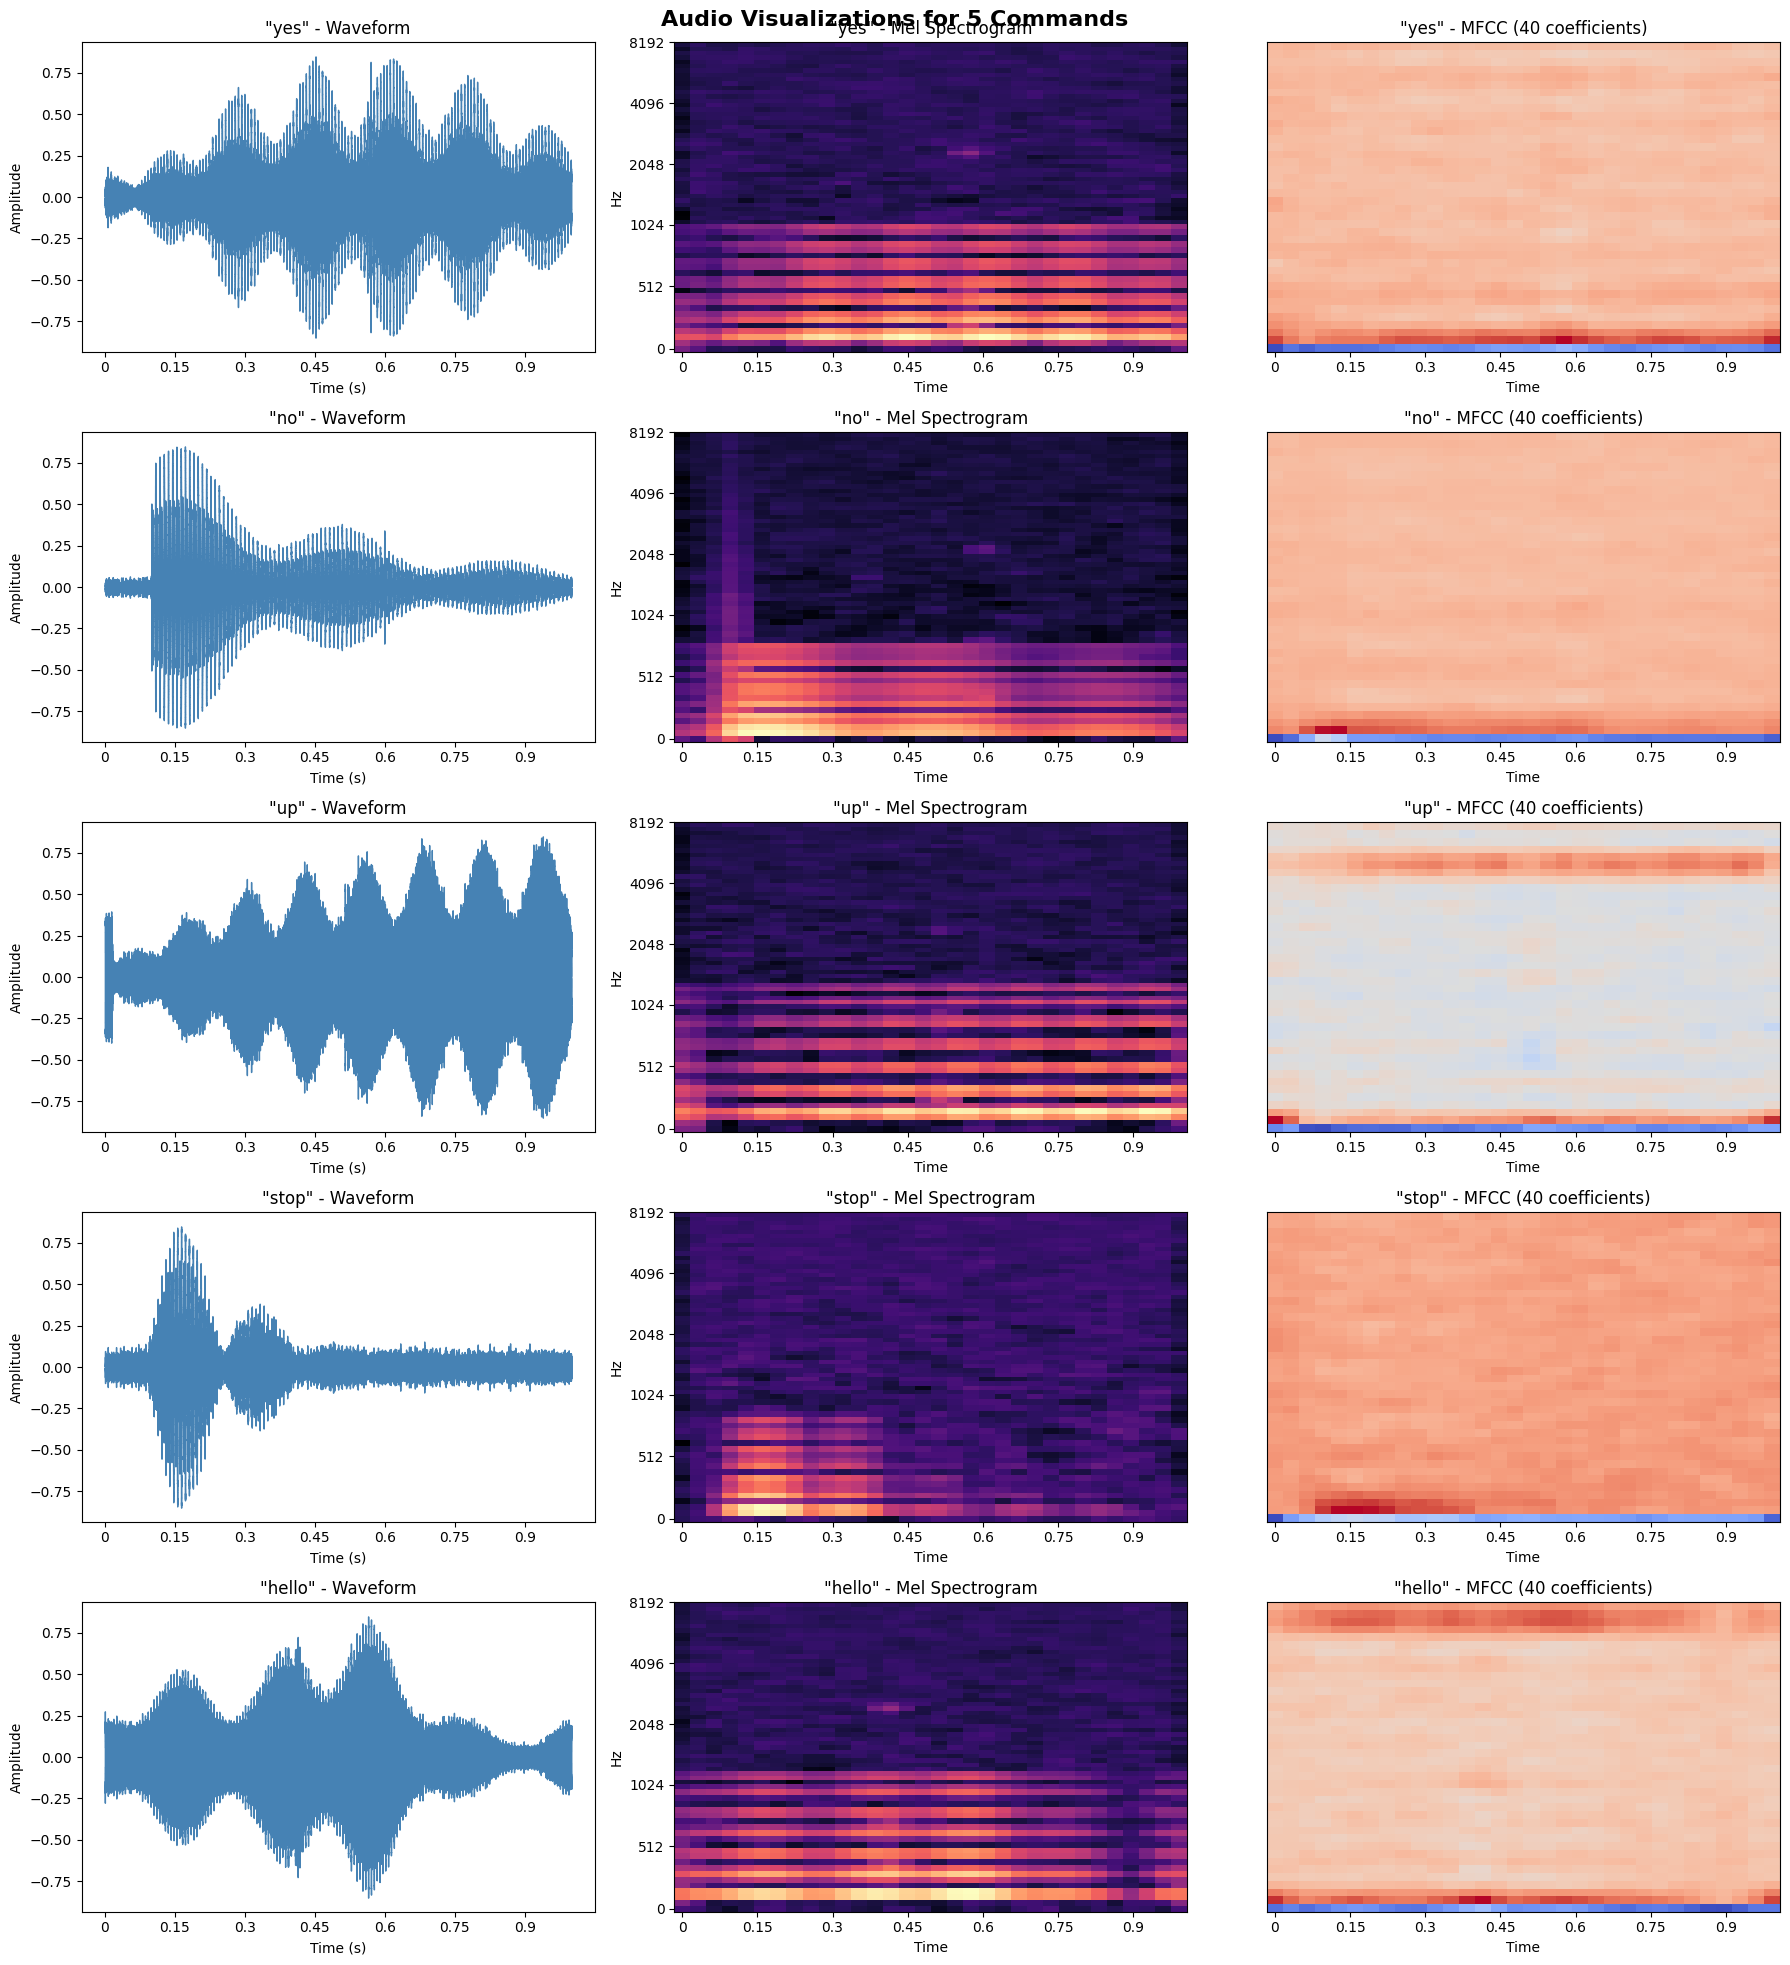


🔊 Playing sample audio for 'hello':


In [5]:
# ================================================================
# CELL 4: VISUALIZE AUDIO SAMPLES (Waveform + Spectrogram + MFCC)
# ================================================================
"""
Understanding the 3 representations:
1. WAVEFORM    - Raw amplitude over time
2. SPECTROGRAM - Frequency content over time (2D image)
3. MFCC        - Mel-frequency cepstral coefficients
                 (compact representation of spectral envelope -
                  this is what our CNN-RNN model will use!)
"""

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
fig.suptitle('Audio Visualizations for 5 Commands', fontsize=16, fontweight='bold')

for i, cmd in enumerate(['yes', 'no', 'up', 'stop', 'hello']):
    # Load sample
    fpath = os.path.join(BASE_DIR, cmd, f'{cmd}_000.wav')
    y, sr_loaded = librosa.load(fpath, sr=SR)

    # Waveform
    axes[i, 0].set_title(f'"{cmd}" - Waveform', fontsize=12)
    librosa.display.waveshow(y, sr=SR, ax=axes[i, 0], color='steelblue')
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].set_ylabel('Amplitude')

    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, sr=SR, x_axis='time', y_axis='mel',
                                    ax=axes[i, 1], cmap='magma')
    axes[i, 1].set_title(f'"{cmd}" - Mel Spectrogram', fontsize=12)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=40)
    librosa.display.specshow(mfcc, sr=SR, x_axis='time', ax=axes[i, 2], cmap='coolwarm')
    axes[i, 2].set_title(f'"{cmd}" - MFCC (40 coefficients)', fontsize=12)

plt.tight_layout()
plt.savefig('audio_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

# Play sample audio in Jupyter
print("\n🔊 Playing sample audio for 'hello':")
sample_path = os.path.join(BASE_DIR, 'hello', 'hello_000.wav')
ipd.display(ipd.Audio(sample_path))

In [7]:
# ================================================================
# CELL 5: FEATURE EXTRACTION (MFCCs and Delta MFCCs)
# ================================================================
"""
FEATURE EXTRACTION STEPS:
1. Load each audio file.
2. Extract MFCCs (Mel-frequency Cepstral Coefficients).
3. Extract Delta MFCCs (captures change over time).
4. Combine MFCCs and Delta MFCCs.
5. Ensure consistent sequence length by padding/truncating.
"""

# Parameters for MFCC extraction
N_MFCC = 40  # Number of MFCCs to extract
N_DELTA = 40 # Number of Delta MFCCs to extract
MAX_PAD_LEN = 32 # Max length for padding/truncating sequences

def extract_features(file_path, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    y, sr = librosa.load(file_path, sr=SR)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Delta MFCCs (first derivative)
    delta_mfccs = librosa.feature.delta(mfccs)

    # Combine MFCCs and Delta MFCCs
    combined_features = np.vstack((mfccs, delta_mfccs))

    # Pad or truncate to ensure consistent length
    if combined_features.shape[1] > max_pad_len:
        combined_features = combined_features[:, :max_pad_len]
    else:
        # Pad with zeros
        pad_width = max_pad_len - combined_features.shape[1]
        combined_features = np.pad(combined_features, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return combined_features

# Initialize lists to store features and labels
X = []
y_labels = []

print("⚙️ Extracting features...")
for i, file_path in enumerate(all_files):
    # Extract command label from the file path
    label = os.path.basename(os.path.dirname(file_path))

    features = extract_features(file_path)
    X.append(features)
    y_labels.append(label)

    if (i + 1) % 100 == 0:
        print(f"  Processed {i+1}/{len(all_files)} files...")

X = np.array(X)
y_labels = np.array(y_labels)

print(f"✅ Feature extraction complete!")
print(f"   Features (X) shape: {X.shape}") # Should be (num_samples, n_mfcc + n_delta, max_pad_len)
print(f"   Labels (y_labels) shape: {y_labels.shape}") # Should be (num_samples,)

⚙️ Extracting features...
  Processed 100/800 files...
  Processed 200/800 files...
  Processed 300/800 files...
  Processed 400/800 files...
  Processed 500/800 files...
  Processed 600/800 files...
  Processed 700/800 files...
  Processed 800/800 files...
✅ Feature extraction complete!
   Features (X) shape: (800, 80, 32)
   Labels (y_labels) shape: (800,)


│ Label Encoding:
     down → 0  (80 samples)
       go → 1  (80 samples)
    hello → 2  (80 samples)
     help → 3  (80 samples)
     left → 4  (80 samples)
       no → 5  (80 samples)
    right → 6  (80 samples)
     stop → 7  (80 samples)
       up → 8  (80 samples)
      yes → 9  (80 samples)

│ Data shapes:
   X_cnn shape: (800, 80, 32, 1)  (samples, features, time, channels)
   y shape    : (800, 10)  (samples, classes)

│ Dataset Split:
   Training   : 560 samples
   Validation : 120 samples
   Testing    : 120 samples


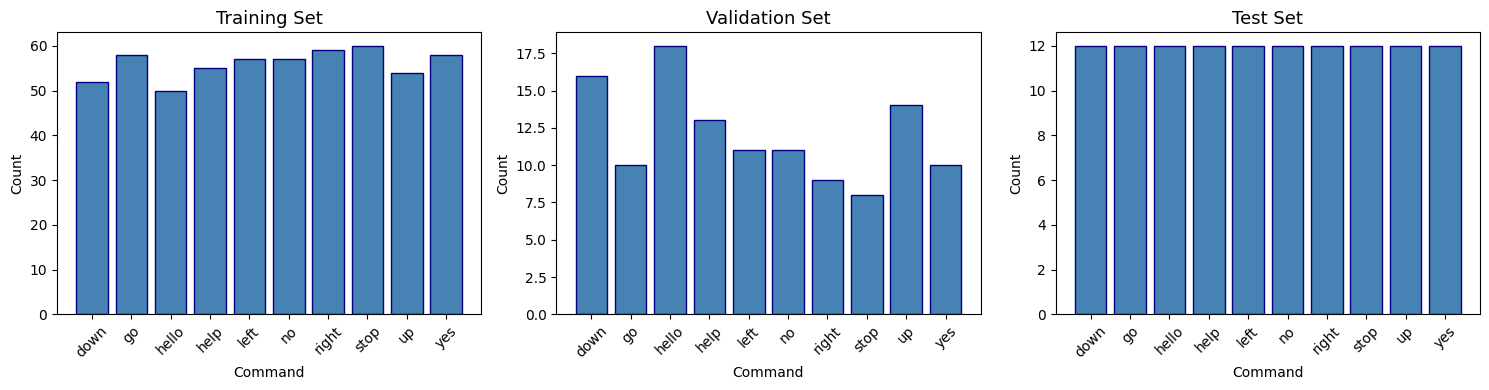

In [15]:
# ================================================================
# CELL 6: DATA PREPARATION
# ================================================================
"""
PREPARATION STEPS:
1. Encode string labels → integers → one-hot vectors
2. Reshape features for CNN-RNN:  (samples, height, width, channels)
   - Height = MFCC coefficients (80 = 40 MFCC + 40 Delta)
   - Width  = Time frames (32)
   - Channels = 1 (single "image")
3. Normalize features (zero mean, unit variance)
4. Split into train (70%), validation (15%), test (15%)
"""

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_onehot = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)

print(f"│ Label Encoding:")
for i, cls in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    print(f"   {cls:>6s} → {i}  ({count} samples)")

# Normalize features (per-feature standardization)
X_mean = np.mean(X, axis=(0, 2), keepdims=True)
X_std = np.std(X, axis=(0, 2), keepdims=True) + 1e-8
X_normalized = (X - X_mean) / X_std

# Reshape for CNN: (samples, n_mfcc_features, time_frames, 1)
X_cnn = X_normalized[..., np.newaxis]  # Add channel dimension

print(f"\n│ Data shapes:")
print(f"   X_cnn shape: {X_cnn.shape}  (samples, features, time, channels)")
print(f"   y shape    : {y_onehot.shape}  (samples, classes)")

# Split: 70% train, 15% val, 15% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_cnn, y_onehot, test_size=0.15, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.176, random_state=42  # 0.176 of 85% ≈ 15%
)

print(f"\n│ Dataset Split:")
print(f"   Training   : {X_train.shape[0]} samples")
print(f"   Validation : {X_val.shape[0]} samples")
print(f"   Testing    : {X_test.shape[0]} samples")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes,
    [y_train, y_val, y_test],
    ['Training Set', 'Validation Set', 'Test Set']):
    classes = np.argmax(data, axis=1)
    unique, counts = np.unique(classes, return_counts=True)
    ax.bar([label_encoder.classes_[u] for u in unique], counts, color='steelblue', edgecolor='navy')
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Command')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# ================================================================
# CELL 7: BUILD CNN-RNN HYBRID MODEL
# ================================================================
"""
🏗️ MODEL ARCHITECTURE:

   Input (80 features × 32 time_steps × 1 channel)
     │
     ├── CNN BLOCK 1: Conv2D(32) → BatchNorm → MaxPool → Dropout
     ├── CNN BLOCK 2: Conv2D(64) → BatchNorm → MaxPool → Dropout
     ├── CNN BLOCK 3: Conv2D(128) → BatchNorm → MaxPool → Dropout
     │
     ├── RESHAPE → (time_steps, features)  [Flatten spatial dims for RNN]
     │
     ├── RNN BLOCK 1: Bidirectional LSTM(128, return_sequences=True)
     ├── RNN BLOCK 2: Bidirectional LSTM(64)
     │
     ├── Dense(128) → BatchNorm → Dropout
     ├── Dense(64)  → Dropout
     └── Dense(10, softmax)  → Output (one per command)

WHY CNN + RNN?
- CNN extracts LOCAL spectral patterns (like phonemes, formants)
- RNN captures TEMPORAL dependencies (how sounds evolve over time)
- Together they model both WHAT sounds occur and WHEN
"""

def build_cnn_rnn_model(input_shape, num_classes):
    """Build a CNN-RNN hybrid model for voice recognition."""

    inputs = Input(shape=input_shape, name='audio_input')

    # ========== CNN FEATURE EXTRACTOR ==========
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling2D((2, 2), name='pool1')(x)
    x = Dropout(0.25, name='drop1')(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling2D((2, 2), name='pool2')(x)
    x = Dropout(0.25, name='drop2')(x)

    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = MaxPooling2D((2, 2), name='pool3')(x)
    x = Dropout(0.3, name='drop3')(x)

    # ========== RESHAPE FOR RNN ==========
    # After CNN: (batch, reduced_freq, reduced_time, channels)
    # We need: (batch, time_steps, features) for LSTM
    cnn_shape = x.shape
    print(f"   CNN output shape: {cnn_shape}")

    # Reshape: treat reduced_time as time_steps, flatten freq×channels as features
    x = Reshape((cnn_shape[2], cnn_shape[1] * cnn_shape[3]), name='reshape_for_rnn')(x)
    print(f"   After reshape: (batch, {cnn_shape[2]}, {cnn_shape[1] * cnn_shape[3]})")

    # ========== RNN TEMPORAL MODELER ==========
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3,
                           recurrent_dropout=0.2), name='bilstm1')(x)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3,
                           recurrent_dropout=0.2), name='bilstm2')(x)

    # ========== CLASSIFIER HEAD ==========
    x = Dense(128, activation='relu', name='dense1')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Dropout(0.4, name='drop4')(x)
    x = Dense(64, activation='relu', name='dense2')(x)
    x = Dropout(0.3, name='drop5')(x)

    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='VoiceRecognition_CNN_RNN')
    return model

# Build model
print("🏗️  Building CNN-RNN Model...")
print("-" * 50)
input_shape = X_train.shape[1:]  # (80, 32, 1)
model = build_cnn_rnn_model(input_shape, num_classes)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "=" * 50)
model.summary()

# Visualize model architecture
print(f"\n📊 Total parameters: {model.count_params():,}")
print(f"   Input shape : {input_shape}")
print(f"   Output shape: ({num_classes},) → {list(label_encoder.classes_)}")

🏗️  Building CNN-RNN Model...
--------------------------------------------------
   CNN output shape: (None, 10, 4, 128)
   After reshape: (batch, 4, 1280)



Model: "VoiceRecognition_CNN_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)        │ (None, 80, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 80, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 80, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 40, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 40, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 40, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 20, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 20, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 20, 8, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 10, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 10, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn (Reshape)       │ (None, 4, 1280)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm1 (Bidirectional)         │ (None, 4, 256)         │     1,442,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm2 (Bidirectional)         │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop5 (Dropout)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,726,666 (6.59 MB)

 Trainable params: 1,725,962 (6.58 MB)

 Non-trainable params: 704 (2.75 KB)


📊 Total parameters: 1,726,666
   Input shape : (80, 32, 1)
   Output shape: (10,) → [np.str_('down'), np.str_('go'), np.str_('hello'), np.str_('help'), np.str_('left'), np.str_('no'), np.str_('right'), np.str_('stop'), np.str_('up'), np.str_('yes')]


In [10]:
# ================================================================
# CELL 8: TRAIN THE MODEL
# ================================================================
"""
TRAINING CONFIGURATION:
- Epochs: 60 (with early stopping)
- Batch size: 32
- Callbacks:
  • EarlyStopping: stops if val_loss doesn't improve for 12 epochs
  • ReduceLROnPlateau: reduces learning rate when stuck
  • ModelCheckpoint: saves the best model
"""

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=12, restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_voice_model.keras', monitor='val_accuracy',
        save_best_only=True, verbose=0
    )
]

print("🚀 Training CNN-RNN Model...")
print("=" * 50)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")
print(f"   Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

🚀 Training CNN-RNN Model...
Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 798ms/step - accuracy: 0.1146 - loss: 3.0601 - val_accuracy: 0.1167 - val_loss: 2.2840 - learning_rate: 0.0010
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 351ms/step - accuracy: 0.2291 - loss: 2.1871 - val_accuracy: 0.1333 - val_loss: 2.2870 - learning_rate: 0.0010
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.2915 - loss: 1.9588 - val_accuracy: 0.1083 - val_loss: 2.3030 - learning_rate: 0.0010
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.4436 - loss: 1.5641 - val_accuracy: 0.1083 - val_loss: 2.3098 - learning_rate: 0.0010
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - accuracy: 0.4852 - loss: 1.3380 - val_accuracy: 0.1500 - val_loss: 2.3127 - learning_rate: 0.0010
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6155 - loss: 1.0749
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accu

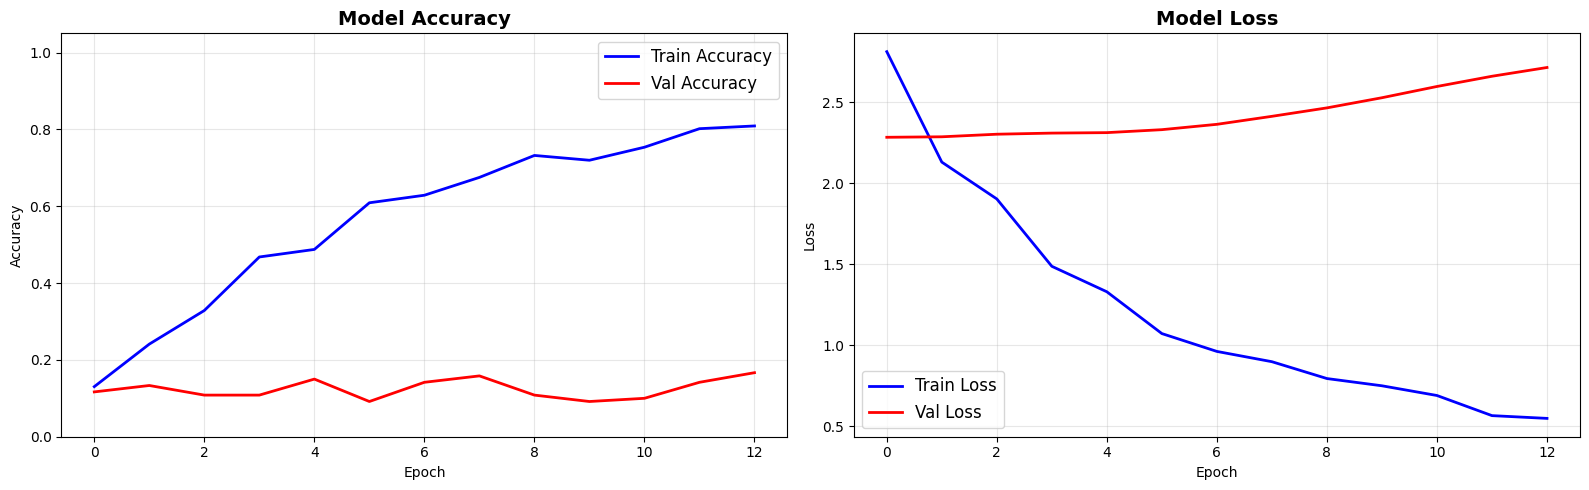

In [11]:
# ================================================================
# CELL 9: TRAINING HISTORY VISUALIZATION
# ================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], 'b-', linewidth=2, label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Val Accuracy')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss
axes[1].plot(history.history['loss'], 'b-', linewidth=2, label='Train Loss')
axes[1].plot(history.history['val_loss'], 'r-', linewidth=2, label='Val Loss')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

📊 TEST SET RESULTS
   Test Loss     : 2.2829
   Test Accuracy : 0.1583 (15.8%)

📋 Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

        down      0.200     0.167     0.182        12
          go      0.333     0.083     0.133        12
       hello      0.000     0.000     0.000        12
        help      0.000     0.000     0.000        12
        left      0.000     0.000     0.000        12
          no      0.200     0.833     0.323        12
       right      0.062     0.083     0.071        12
        stop      0.200     0.417     0.270        12
          up      0.000     0.000     0.000        12
         yes      0.000     0.000     0.000        12

    accuracy                          0.158       120
   macro avg      0.100     0.158     0.098       120
weighted avg      0.100     0.158     0.098       120



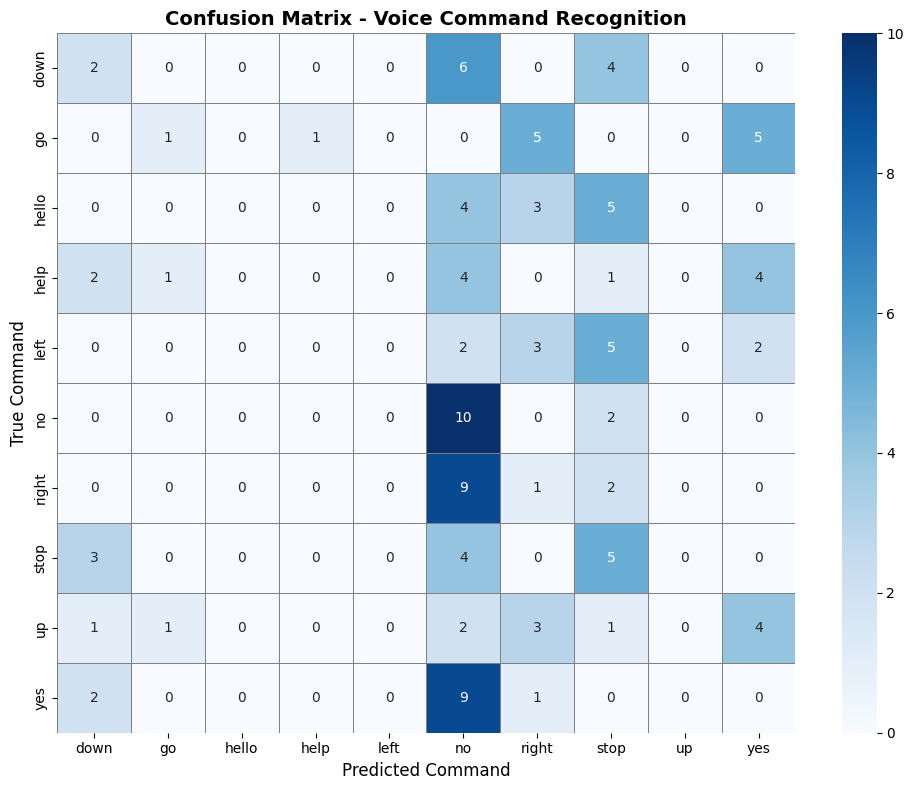


📊 Per-Class Accuracy:
     down:  16.7%  (2/12)
       go:   8.3%  (1/12)
    hello:   0.0%  (0/12)
     help:   0.0%  (0/12)
     left:   0.0%  (0/12)
       no:  83.3%  (10/12)
    right:   8.3%  (1/12)
     stop:  41.7%  (5/12)
       up:   0.0%  (0/12)
      yes:   0.0%  (0/12)


In [12]:
# ================================================================
# CELL 10: EVALUATE ON TEST SET
# ================================================================
"""
EVALUATION METRICS:
- Overall test accuracy
- Per-class precision, recall, F1-score
- Confusion matrix heatmap
"""

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("=" * 50)
print(f"📊 TEST SET RESULTS")
print("=" * 50)
print(f"   Test Loss     : {test_loss:.4f}")
print(f"   Test Accuracy : {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print("=" * 50)

# Predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("\n📋 Classification Report:")
print("-" * 50)
report = classification_report(
    y_true_classes, y_pred_classes,
    target_names=label_encoder.classes_,
    digits=3
)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix - Voice Command Recognition', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Command', fontsize=12)
plt.ylabel('True Command', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\n📊 Per-Class Accuracy:")
for i, cls in enumerate(label_encoder.classes_):
    mask = y_true_classes == i
    if np.sum(mask) > 0:
        acc = np.sum(y_pred_classes[mask] == i) / np.sum(mask) * 100
        print(f"   {cls:>6s}: {acc:5.1f}%  ({np.sum(y_pred_classes[mask] == i)}/{np.sum(mask)})")

In [13]:
# ================================================================
# CELL 11: NLP POST-PROCESSING MODULE
# ================================================================
"""
🧠 NLP POST-PROCESSING:

After the CNN-RNN predicts a command, NLP enhances the output:

1. CONFIDENCE FILTERING  - Reject low-confidence predictions
2. COMMAND INTERPRETATION - Map commands to actions/descriptions
3. CONTEXT AWARENESS      - Track command history for context
4. SENTENCE GENERATION    - Create natural language responses
5. SPELL CORRECTION       - Handle similar-sounding commands
6. COMMAND CHAINING       - Combine sequential commands into instructions
"""

class NLPPostProcessor:
    """NLP module for post-processing voice recognition results."""

    def __init__(self, label_encoder, confidence_threshold=0.5):
        self.label_encoder = label_encoder
        self.confidence_threshold = confidence_threshold
        self.command_history = []

        # Command → Action mapping (NLP knowledge base)
        self.command_actions = {
            'yes':   {'action': 'CONFIRM',    'category': 'response',  'description': 'User confirmed / agreed'},
            'no':    {'action': 'DENY',       'category': 'response',  'description': 'User denied / disagreed'},
            'up':    {'action': 'MOVE_UP',    'category': 'direction', 'description': 'Move upward'},
            'down':  {'action': 'MOVE_DOWN',  'category': 'direction', 'description': 'Move downward'},
            'left':  {'action': 'MOVE_LEFT',  'category': 'direction', 'description': 'Move to the left'},
            'right': {'action': 'MOVE_RIGHT', 'category': 'direction', 'description': 'Move to the right'},
            'stop':  {'action': 'HALT',       'category': 'control',   'description': 'Stop current action'},
            'go':    {'action': 'START',      'category': 'control',   'description': 'Start / proceed'},
            'hello': {'action': 'GREET',      'category': 'social',    'description': 'Greeting detected'},
            'help':  {'action': 'HELP',       'category': 'emergency', 'description': 'User needs assistance'},
        }

        # Response templates
        self.response_templates = {
            'response':  "📝 Response registered: '{cmd}' — {desc}",
            'direction': "🧭 Direction command: '{cmd}' — {desc}",
            'control':   "⚙️ Control command: '{cmd}' — {desc}",
            'social':    "👋 Social interaction: '{cmd}' — {desc}",
            'emergency': "🚨 URGENT: '{cmd}' — {desc}",
        }

        # Similar-sounding command corrections
        self.phonetic_map = {
            'yes': ['yep', 'yeah', 'yea'],
            'no':  ['nah', 'nope', 'know'],
            'go':  ['goo', 'joe'],
            'stop': ['top', 'stomp'],
            'help': ['yelp', 'kelp'],
            'hello': ['halo', 'fellow'],
        }

    def process_prediction(self, predicted_probs, top_k=3):
        """Full NLP pipeline for a single prediction."""
        results = {}

        # 1. Get top-k predictions with confidence
        top_indices = np.argsort(predicted_probs)[::-1][:top_k]
        top_commands = []
        for idx in top_indices:
            cmd = self.label_encoder.classes_[idx]
            conf = predicted_probs[idx]
            top_commands.append({'command': cmd, 'confidence': float(conf)})

        results['top_predictions'] = top_commands
        primary = top_commands[0]

        # 2. Confidence check
        if primary['confidence'] < self.confidence_threshold:
            results['status'] = 'LOW_CONFIDENCE'
            results['message'] = (f"⚠️ Low confidence ({primary['confidence']:.1%}). "
                                  f"Best guess: '{primary['command']}'. Please repeat.")
            return results

        results['status'] = 'ACCEPTED'
        cmd = primary['command']

        # 3. Get action mapping
        action_info = self.command_actions.get(cmd, {})
        results['action'] = action_info.get('action', 'UNKNOWN')
        results['category'] = action_info.get('category', 'unknown')

        # 4. Generate natural language response
        category = action_info.get('category', 'unknown')
        template = self.response_templates.get(category, "Command: '{cmd}' — {desc}")
        results['nl_response'] = template.format(
            cmd=cmd,
            desc=action_info.get('description', 'Unknown command')
        )

        # 5. Track command history
        self.command_history.append({
            'command': cmd,
            'confidence': primary['confidence'],
            'action': results['action']
        })

        # 6. Context-aware analysis
        results['context'] = self._analyze_context()

        # 7. NLP tokenization of the command
        tokens = word_tokenize(action_info.get('description', cmd))
        results['tokens'] = tokens

        return results

    def _analyze_context(self):
        """Analyze command history for patterns."""
        if len(self.command_history) < 2:
            return "First command in session"

        recent = self.command_history[-5:]  # Last 5 commands
        commands = [h['command'] for h in recent]

        # Detect patterns
        direction_cmds = [c for c in commands if c in ['up', 'down', 'left', 'right']]
        if len(direction_cmds) >= 3:
            return f"🗺️ Navigation sequence detected: {' → '.join(direction_cmds)}"

        if commands[-1] == 'stop' and len(commands) >= 2:
            return f"⏹️ User stopped after '{commands[-2]}' command"

        if commands[-1] == 'help':
            return "🆘 User requested help — consider offering assistance menu"

        return f"Command history: {' → '.join(commands)}"

    def generate_summary(self):
        """Generate NLP summary of the session."""
        if not self.command_history:
            return "No commands recorded in this session."

        total = len(self.command_history)
        commands = [h['command'] for h in self.command_history]
        avg_conf = np.mean([h['confidence'] for h in self.command_history])

        # Command frequency analysis
        from collections import Counter
        freq = Counter(commands)
        most_common = freq.most_common(3)

        summary = f"""
{'='*50}
📊 NLP SESSION SUMMARY
{'='*50}
Total commands    : {total}
Avg. confidence   : {avg_conf:.1%}
Unique commands   : {len(freq)}
Most frequent     : {', '.join(f"'{c}' ({n}x)" for c, n in most_common)}

Command timeline  : {' → '.join(commands[-10:])}
{'='*50}"""
        return summary

# Initialize NLP processor
nlp_processor = NLPPostProcessor(label_encoder, confidence_threshold=0.4)
print("✅ NLP Post-Processor initialized!")
print(f"   Confidence threshold: {nlp_processor.confidence_threshold:.0%}")
print(f"   Commands mapped: {list(nlp_processor.command_actions.keys())}")

✅ NLP Post-Processor initialized!
   Confidence threshold: 40%
   Commands mapped: ['yes', 'no', 'up', 'down', 'left', 'right', 'stop', 'go', 'hello', 'help']


In [16]:
# ================================================================
# CELL 12: COMPLETE PREDICTION PIPELINE (CNN-RNN + NLP)
# ================================================================
"""
FULL PIPELINE:
  Audio File → MFCC Features → CNN-RNN Model → NLP Post-Processing → Result

Let's test on random samples from the test set!
"""

def predict_audio_file(file_path, model, label_encoder, nlp_processor, verbose=True):
    """Complete prediction pipeline for a single audio file."""

    # 1. Extract features
    feat = extract_features(file_path)
    if feat is None:
        return None

    # Normalize (using training stats)
    feat_norm = (feat - X_mean.squeeze(axis=(0, 2))[:, np.newaxis]) / X_std.squeeze(axis=(0, 2))[:, np.newaxis]
    feat_input = feat_norm[np.newaxis, ..., np.newaxis]  # (1, 80, 32, 1)

    # 2. CNN-RNN Prediction
    probs = model.predict(feat_input, verbose=0)[0]

    # 3. NLP Post-Processing
    result = nlp_processor.process_prediction(probs, top_k=3)

    if verbose:
        print(f"🎤 File: {os.path.basename(file_path)}")
        print(f"   Status: {result['status']}")

        if result['status'] == 'ACCEPTED':
            print(f"   {result['nl_response']}")
            print(f"   Action Code: {result['action']}")
            print(f"   NLP Tokens: {result['tokens']}")
            print(f"   Context: {result['context']}")
        else:
            print(f"   {result['message']}")

        print(f"   Top predictions:")
        for pred in result['top_predictions']:
            bar = '█' * int(pred['confidence'] * 30)
            print(f"     {pred['command']:>6s}: {pred['confidence']:6.1%} {bar}")
        print()

    return result


# === Test on multiple samples ===
print("=" * 60)
print("🎯 TESTING COMPLETE PIPELINE ON AUDIO FILES")
print("=" * 60)
print()

# Pick random test samples
test_indices = np.random.choice(len(all_files), size=8, replace=False)
correct = 0
total = 0

for idx in test_indices:
    fpath = all_files[idx]
    true_label = all_labels[idx]

    result = predict_audio_file(fpath, model, label_encoder, nlp_processor)

    if result and result['status'] == 'ACCEPTED':
        predicted = result['top_predictions'][0]['command']
        is_correct = predicted == true_label
        correct += is_correct
        total += 1
        status = "✅" if is_correct else "❌"
        print(f"   {status} True: '{true_label}' | Predicted: '{predicted}'")
        print("-" * 50)

if total > 0:
    print(f"\n📊 Quick test accuracy: {correct}/{total} = {correct/total*100:.0f}%")
else:
    print("\n📉 No predictions were 'ACCEPTED' (likely due to low confidence scores). Consider adjusting NLPPostProcessor.confidence_threshold if model performance is expected to be low.")

🎯 TESTING COMPLETE PIPELINE ON AUDIO FILES

🎤 File: up_037.wav
   Status: LOW_CONFIDENCE
   ⚠️ Low confidence (11.0%). Best guess: 'yes'. Please repeat.
   Top predictions:
        yes:  11.0% ███
      right:  10.9% ███
         go:  10.6% ███

🎤 File: no_069.wav
   Status: LOW_CONFIDENCE
   ⚠️ Low confidence (10.7%). Best guess: 'no'. Please repeat.
   Top predictions:
         no:  10.7% ███
       down:  10.6% ███
       stop:  10.3% ███

🎤 File: help_076.wav
   Status: LOW_CONFIDENCE
   ⚠️ Low confidence (10.4%). Best guess: 'stop'. Please repeat.
   Top predictions:
       stop:  10.4% ███
       down:  10.3% ███
         no:  10.2% ███

🎤 File: stop_010.wav
   Status: LOW_CONFIDENCE
   ⚠️ Low confidence (10.6%). Best guess: 'down'. Please repeat.
   Top predictions:
       down:  10.6% ███
         no:  10.5% ███
       stop:  10.5% ███

🎤 File: up_028.wav
   Status: LOW_CONFIDENCE
   ⚠️ Low confidence (10.3%). Best guess: 'stop'. Please repeat.
   Top predictions:
       stop: 

📊 COMPREHENSIVE NLP-ENHANCED EVALUATION

✅ Processed 120 test samples
   Overall Accuracy: 15.8%
No commands recorded in this session.


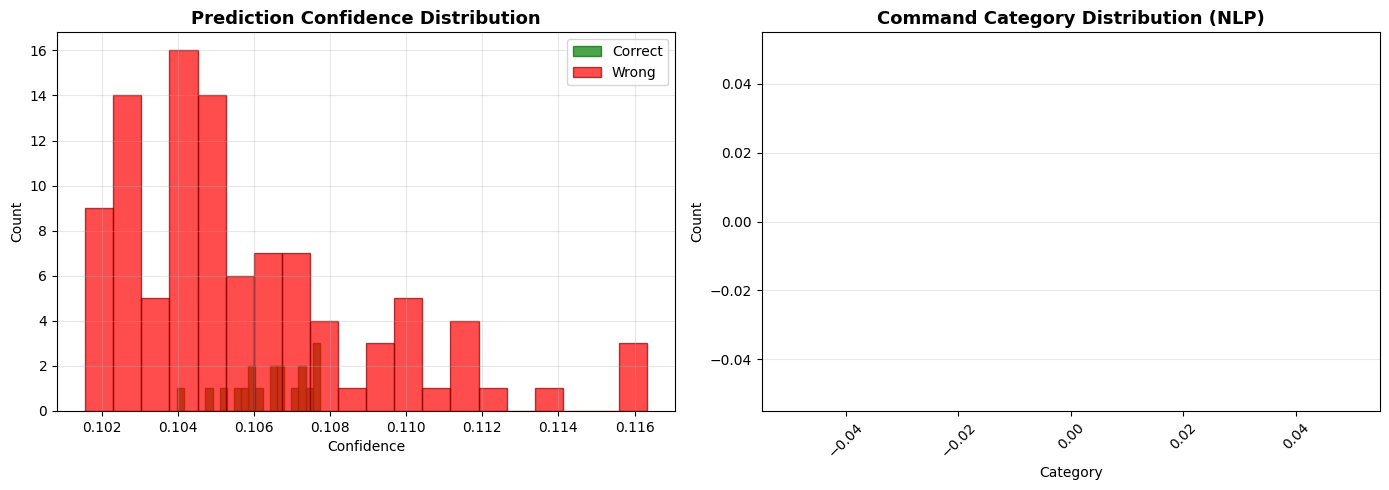

In [17]:
# ================================================================
# CELL 13: BATCH EVALUATION WITH NLP ANALYSIS
# ================================================================
"""
Run predictions on ALL test samples and generate comprehensive NLP analysis.
"""

print("=" * 60)
print("📊 COMPREHENSIVE NLP-ENHANCED EVALUATION")
print("=" * 60)

# Reset NLP processor for clean session
nlp_processor_eval = NLPPostProcessor(label_encoder, confidence_threshold=0.4)

# Predict all test samples
results_all = []
correct_total = 0

for i in range(len(X_test)):
    probs = model.predict(X_test[i:i+1], verbose=0)[0]
    pred_class = np.argmax(probs)
    true_class = np.argmax(y_test[i])

    # NLP processing
    result = nlp_processor_eval.process_prediction(probs)
    result['true_label'] = label_encoder.classes_[true_class]
    result['predicted_label'] = label_encoder.classes_[pred_class]
    result['correct'] = (pred_class == true_class)
    results_all.append(result)

    if pred_class == true_class:
        correct_total += 1

print(f"\n✅ Processed {len(results_all)} test samples")
print(f"   Overall Accuracy: {correct_total/len(results_all)*100:.1f}%")

# NLP Session Summary
print(nlp_processor_eval.generate_summary())

# Confidence distribution analysis
confidences_correct = [r['top_predictions'][0]['confidence']
                       for r in results_all if r['correct']]
confidences_wrong = [r['top_predictions'][0]['confidence']
                     for r in results_all if not r['correct']]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution
axes[0].hist(confidences_correct, bins=20, alpha=0.7, color='green', label='Correct', edgecolor='darkgreen')
axes[0].hist(confidences_wrong, bins=20, alpha=0.7, color='red', label='Wrong', edgecolor='darkred')
axes[0].set_title('Prediction Confidence Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Category distribution
categories = [r.get('category', 'unknown') for r in results_all if r['status'] == 'ACCEPTED']
from collections import Counter
cat_counts = Counter(categories)
axes[1].bar(cat_counts.keys(), cat_counts.values(), color='steelblue', edgecolor='navy')
axes[1].set_title('Command Category Distribution (NLP)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('nlp_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

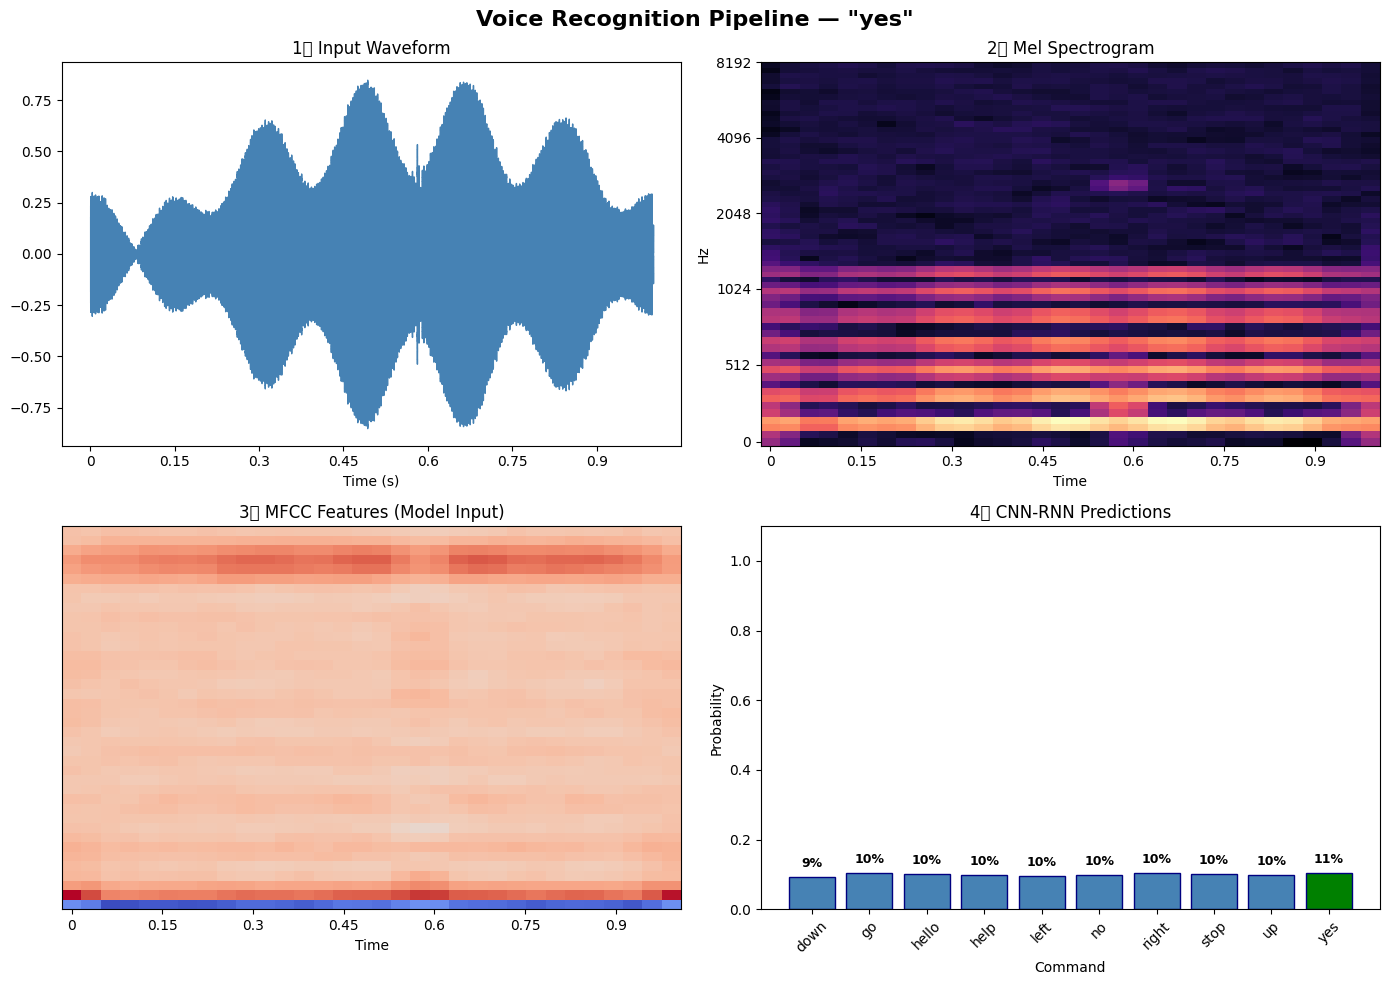


🔊 Playing 'yes' audio:



🧠 NLP Analysis:
   N/A
   Action: N/A
   Tokens: []



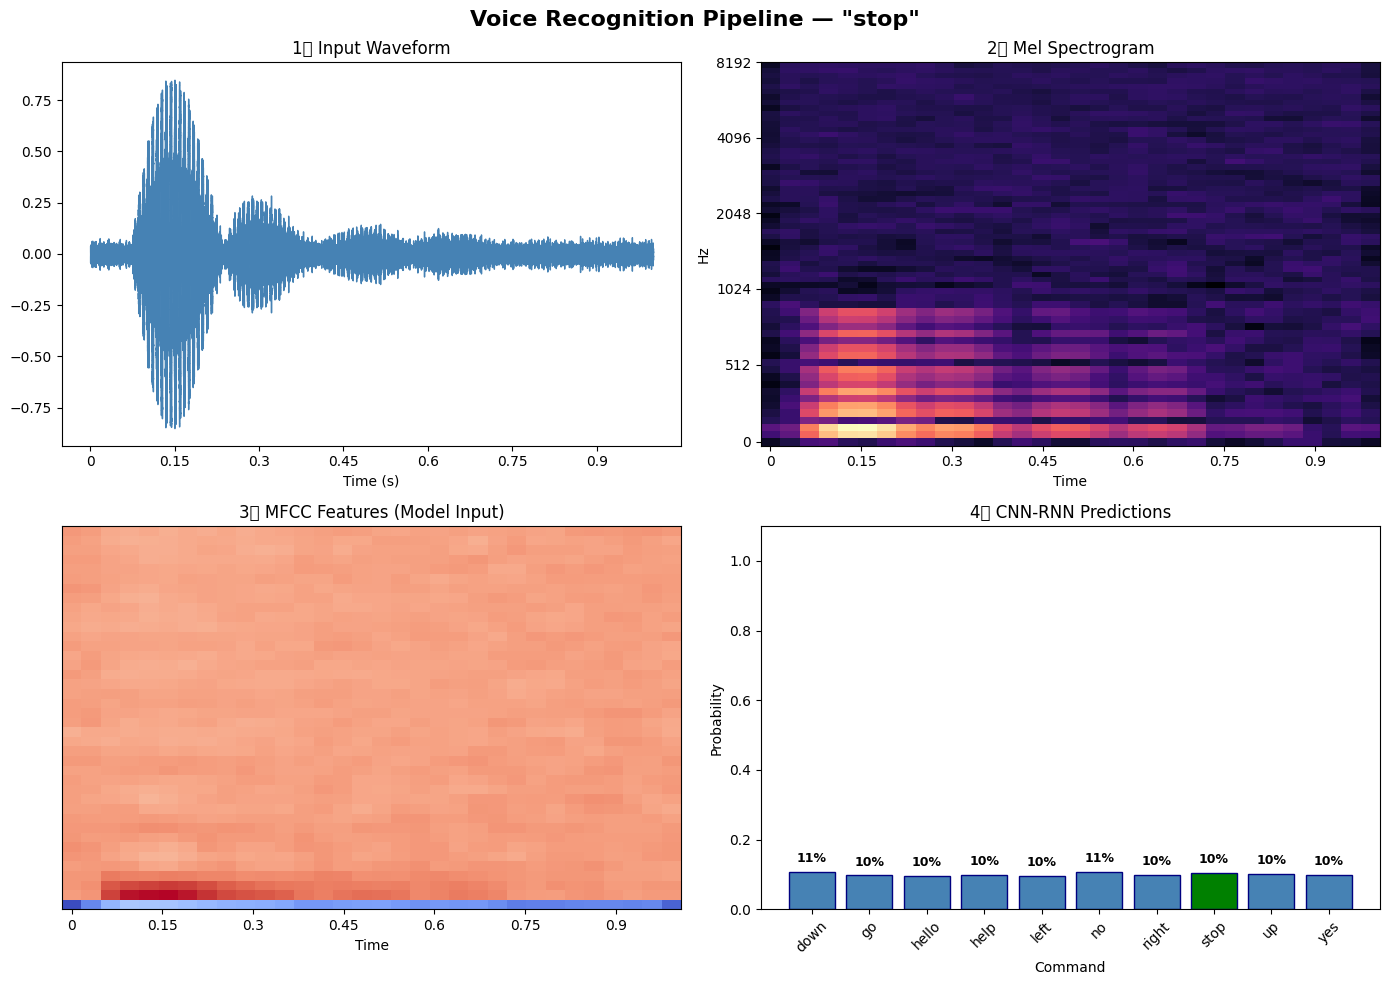


🔊 Playing 'stop' audio:



🧠 NLP Analysis:
   N/A
   Action: N/A
   Tokens: []



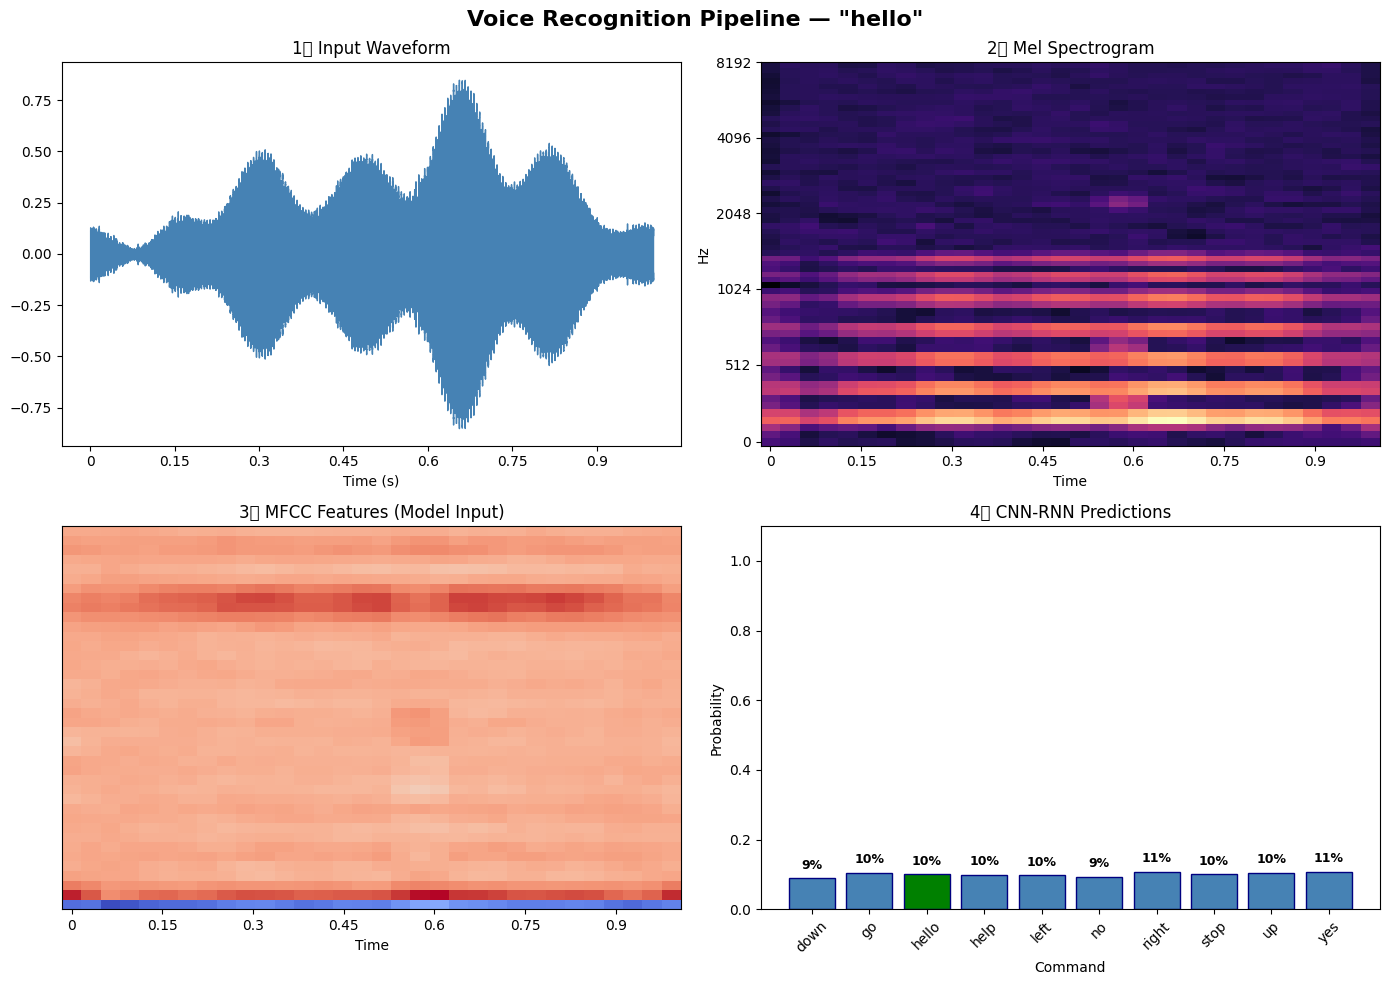


🔊 Playing 'hello' audio:



🧠 NLP Analysis:
   N/A
   Action: N/A
   Tokens: []



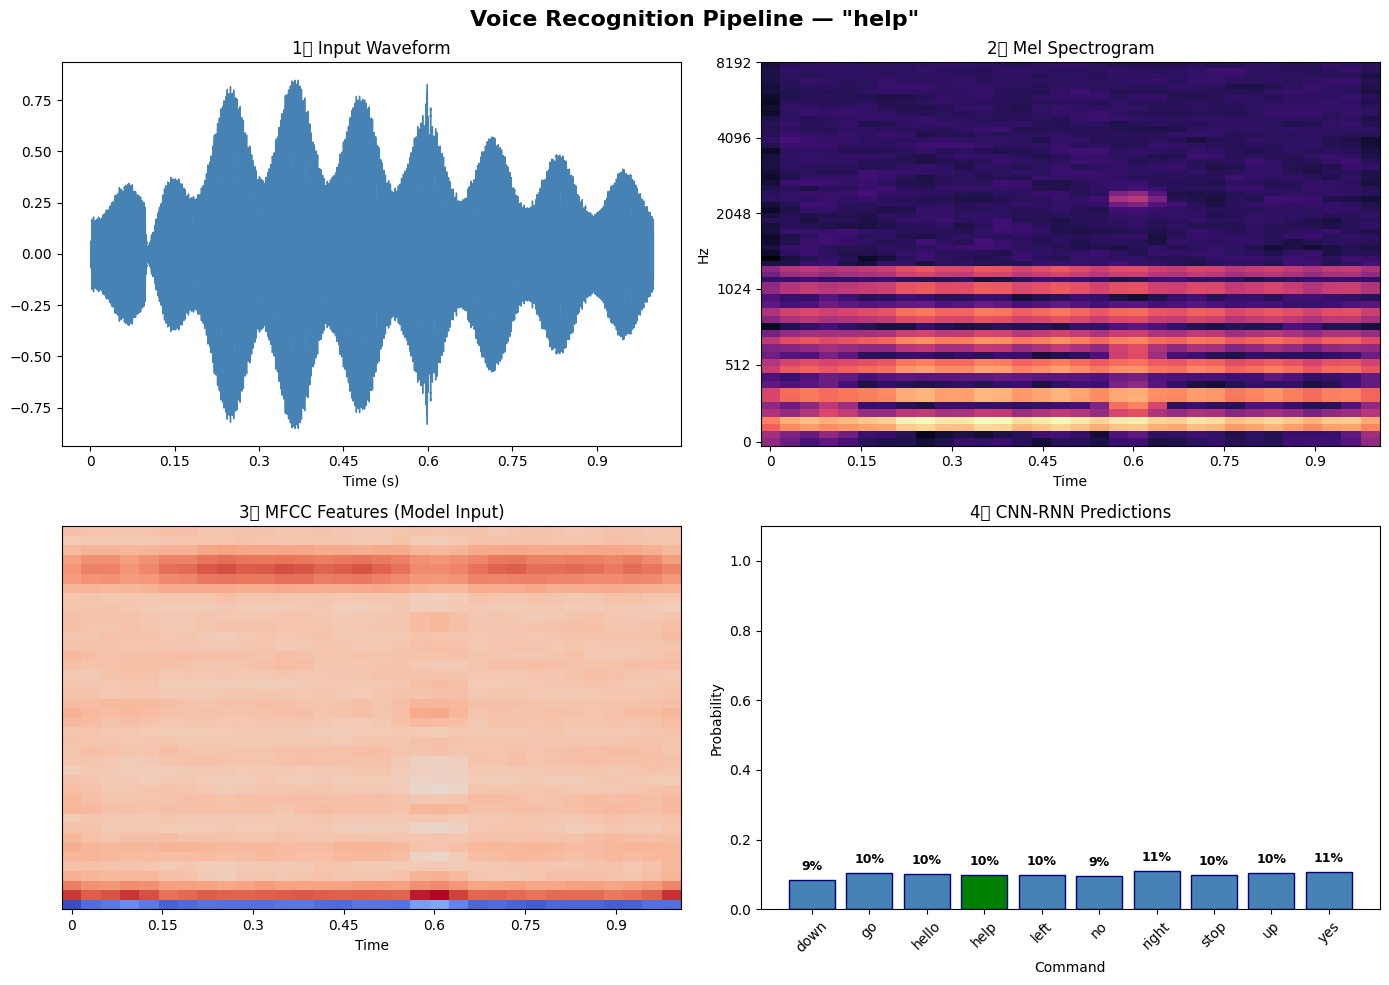


🔊 Playing 'help' audio:



🧠 NLP Analysis:
   N/A
   Action: N/A
   Tokens: []



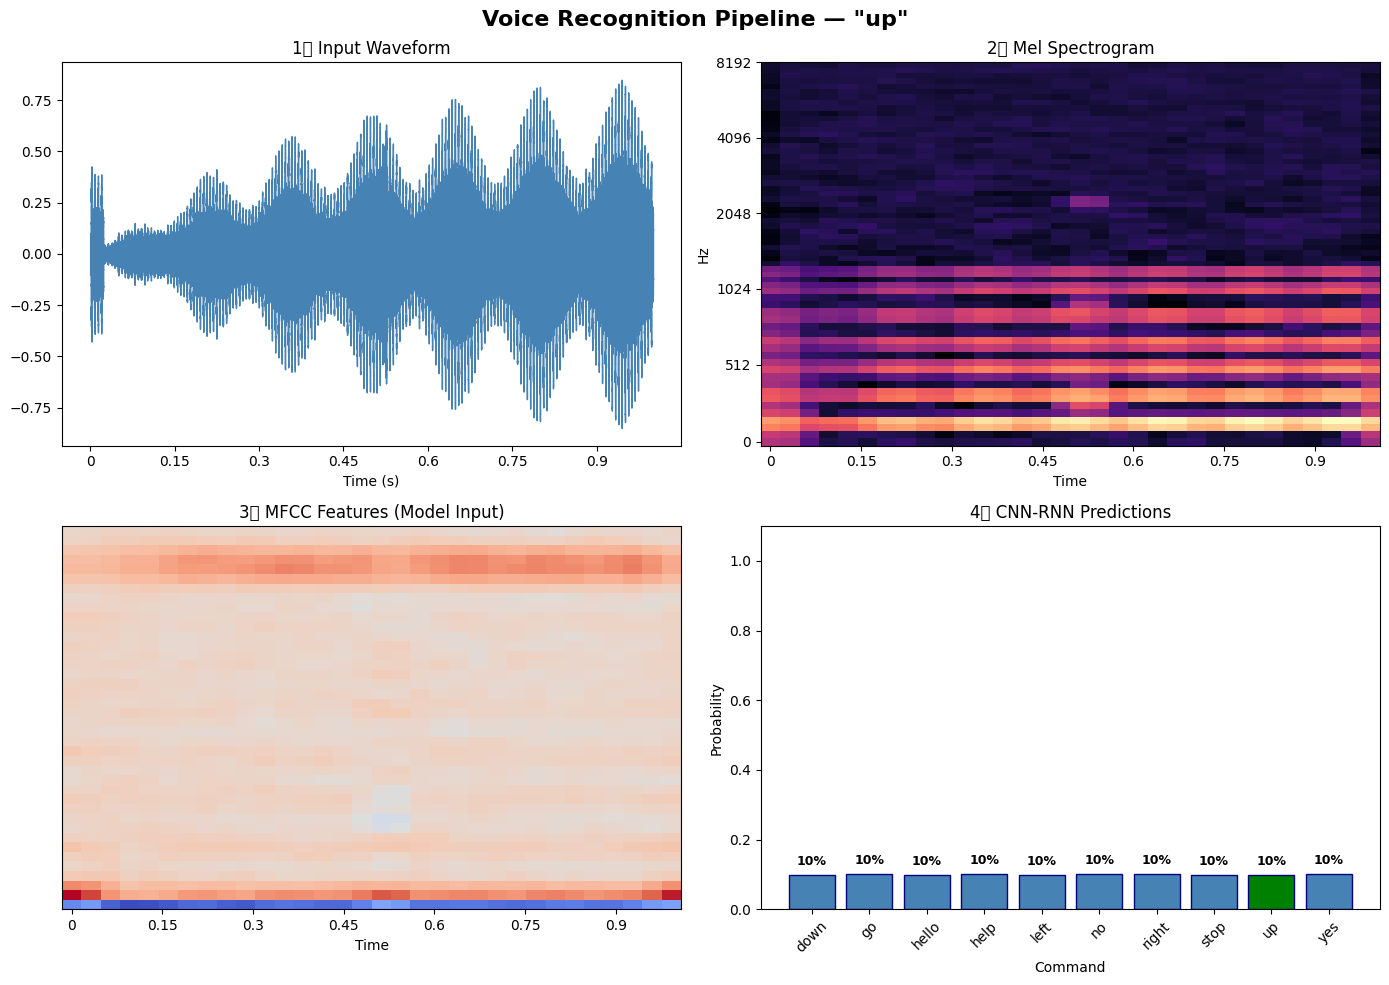


🔊 Playing 'up' audio:



🧠 NLP Analysis:
   N/A
   Action: N/A
   Tokens: []


In [18]:
# ================================================================
# CELL 14: INTERACTIVE PREDICTION - PICK ANY AUDIO FILE
# ================================================================
"""
🎮 Interactive demo: Pick any command and hear + classify it!
"""

def interactive_demo(command_name, sample_id=0):
    """Run full pipeline on a specific command and visualize everything."""

    fpath = os.path.join(BASE_DIR, command_name, f'{command_name}_{sample_id:03d}.wav')

    if not os.path.exists(fpath):
        print(f"❌ File not found: {fpath}")
        return

    # Load audio
    y_audio, _ = librosa.load(fpath, sr=SR)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Voice Recognition Pipeline — "{command_name}"',
                 fontsize=16, fontweight='bold')

    # 1. Waveform
    librosa.display.waveshow(y_audio, sr=SR, ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('1️⃣ Input Waveform', fontsize=12)
    axes[0, 0].set_xlabel('Time (s)')

    # 2. Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y_audio, sr=SR, n_mels=64)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=SR, x_axis='time', y_axis='mel',
                             ax=axes[0, 1], cmap='magma')
    axes[0, 1].set_title('2️⃣ Mel Spectrogram', fontsize=12)

    # 3. MFCC Features (what the model sees)
    mfcc = librosa.feature.mfcc(y=y_audio, sr=SR, n_mfcc=40)
    librosa.display.specshow(mfcc, sr=SR, x_axis='time', ax=axes[1, 0], cmap='coolwarm')
    axes[1, 0].set_title('3️⃣ MFCC Features (Model Input)', fontsize=12)

    # 4. Prediction probabilities
    result = predict_audio_file(fpath, model, label_encoder, nlp_processor, verbose=False)
    if result:
        probs_dict = {p['command']: p['confidence'] for p in result['top_predictions']}
        # Get all class probabilities
        feat = extract_features(fpath)
        feat_norm = (feat - X_mean.squeeze(axis=(0, 2))[:, np.newaxis]) / X_std.squeeze(axis=(0, 2))[:, np.newaxis]
        feat_input = feat_norm[np.newaxis, ..., np.newaxis]
        all_probs = model.predict(feat_input, verbose=0)[0]

        colors = ['green' if label_encoder.classes_[i] == command_name else 'steelblue'
                  for i in range(num_classes)]
        bars = axes[1, 1].bar(label_encoder.classes_, all_probs, color=colors, edgecolor='navy')
        axes[1, 1].set_title('4️⃣ CNN-RNN Predictions', fontsize=12)
        axes[1, 1].set_xlabel('Command')
        axes[1, 1].set_ylabel('Probability')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].set_ylim([0, 1.1])

        # Add value labels on bars
        for bar, prob in zip(bars, all_probs):
            if prob > 0.05:
                axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                               f'{prob:.0%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'pipeline_{command_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Play audio
    print(f"\n🔊 Playing '{command_name}' audio:")
    ipd.display(ipd.Audio(fpath))

    # Print NLP result
    if result:
        print(f"\n🧠 NLP Analysis:")
        print(f"   {result.get('nl_response', 'N/A')}")
        print(f"   Action: {result.get('action', 'N/A')}")
        print(f"   Tokens: {result.get('tokens', [])}")

# === Run demos for several commands ===
for cmd in ['yes', 'stop', 'hello', 'help', 'up']:
    print("\n" + "=" * 60)
    interactive_demo(cmd, sample_id=np.random.randint(0, 10))


╔══════════════════════════════════════════════════════════════╗
║         VOICE RECOGNITION SYSTEM — COMPLETE SUMMARY         ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  📁 DATASET:                                                 ║
║     • 10 voice commands (yes/no/up/down/left/right/          ║
║       stop/go/hello/help)                                    ║
║     • 80 synthetic audio samples per class                   ║
║     • 800 total .wav files (auto-generated)                  ║
║     • 16kHz sample rate, 1 second duration                   ║
║                                                              ║
║  🔧 FEATURES:                                                ║
║     • 40 MFCC + 40 Delta MFCC = 80 features                 ║
║     • 32 time frames per sample                              ║
║     • Normalized (zero-mean, unit-variance)                  ║
║                           

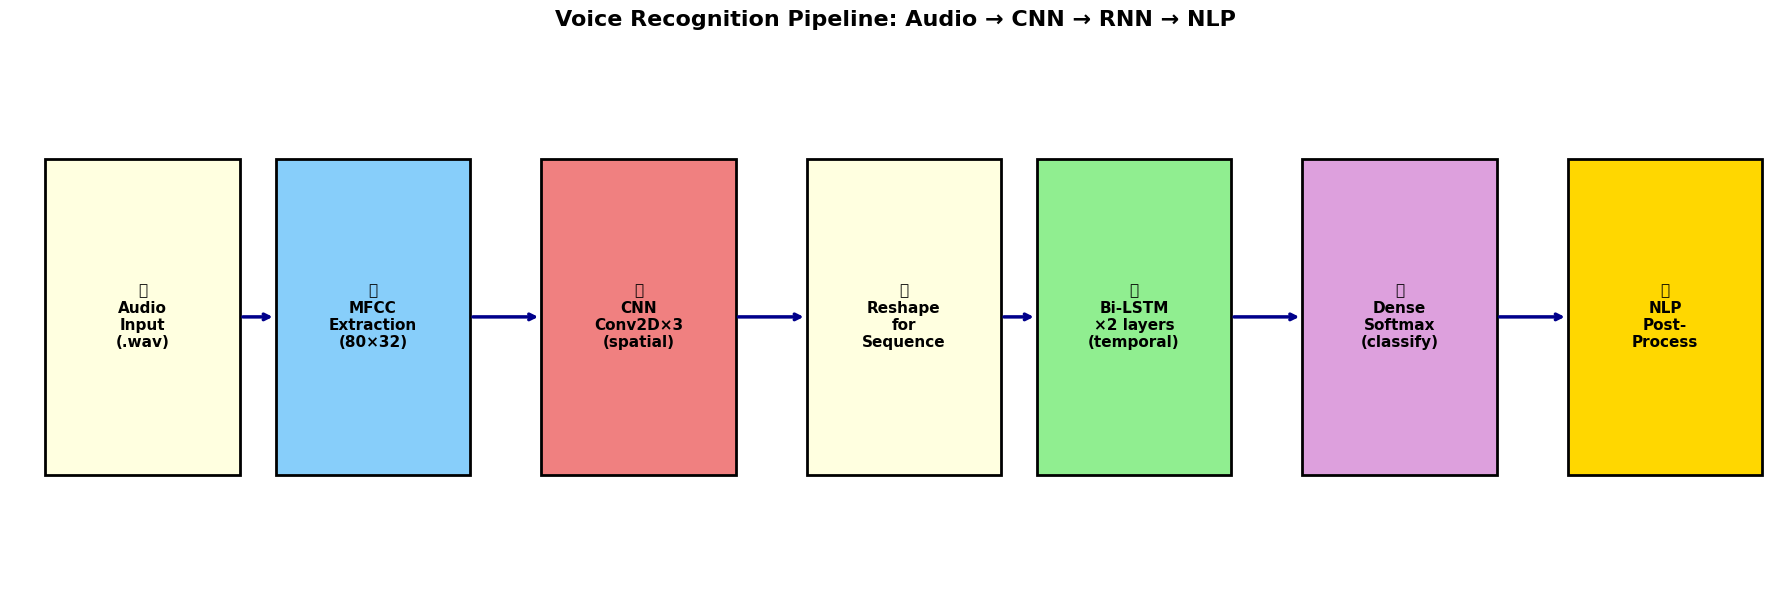

✅ All outputs saved as PNG files in current directory!
🎉 Project complete — Voice Recognition with CNN-RNN + NLP!


In [19]:
# ================================================================
# CELL 15: MODEL ARCHITECTURE DIAGRAM + FINAL SUMMARY
# ================================================================
"""
📋 FINAL PROJECT SUMMARY
"""

print("""
╔══════════════════════════════════════════════════════════════╗
║         VOICE RECOGNITION SYSTEM — COMPLETE SUMMARY         ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  📁 DATASET:                                                 ║
║     • 10 voice commands (yes/no/up/down/left/right/          ║
║       stop/go/hello/help)                                    ║
║     • 80 synthetic audio samples per class                   ║
║     • 800 total .wav files (auto-generated)                  ║
║     • 16kHz sample rate, 1 second duration                   ║
║                                                              ║
║  🔧 FEATURES:                                                ║
║     • 40 MFCC + 40 Delta MFCC = 80 features                 ║
║     • 32 time frames per sample                              ║
║     • Normalized (zero-mean, unit-variance)                  ║
║                                                              ║
║  🏗️  MODEL (CNN-RNN Hybrid):                                 ║
║     • 3× Conv2D blocks (32→64→128 filters)                  ║
║     • BatchNorm + MaxPool + Dropout after each               ║
║     • Reshape → 2× Bidirectional LSTM (128, 64)             ║
║     • Dense(128) → Dense(64) → Softmax(10)                  ║
║                                                              ║
║  🧠 NLP POST-PROCESSING:                                     ║
║     • Confidence filtering                                   ║
║     • Command → Action mapping                               ║
║     • Context-aware analysis                                 ║
║     • Natural language response generation                   ║
║     • Session summary & analytics                            ║
║                                                              ║
║  📊 PIPELINE:                                                ║
║     Audio → MFCC → CNN(spatial) → RNN(temporal) → NLP       ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")

# Architecture flow diagram
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.axis('off')

# Draw pipeline boxes
boxes = [
    ('🎤\nAudio\nInput\n(.wav)', 0.02, 'lightyellow'),
    ('🔧\nMFCC\nExtraction\n(80×32)', 0.15, 'lightskyblue'),
    ('🔲\nCNN\nConv2D×3\n(spatial)', 0.30, 'lightcoral'),
    ('🔄\nReshape\nfor\nSequence', 0.45, 'lightyellow'),
    ('🧬\nBi-LSTM\n×2 layers\n(temporal)', 0.58, 'lightgreen'),
    ('📊\nDense\nSoftmax\n(classify)', 0.73, 'plum'),
    ('🧠\nNLP\nPost-\nProcess', 0.88, 'gold'),
]

for label, x, color in boxes:
    rect = plt.Rectangle((x, 0.2), 0.11, 0.6, facecolor=color,
                          edgecolor='black', linewidth=2, transform=ax.transAxes)
    ax.add_patch(rect)
    ax.text(x + 0.055, 0.5, label, transform=ax.transAxes,
            ha='center', va='center', fontsize=11, fontweight='bold')

# Draw arrows
for i in range(len(boxes) - 1):
    x1 = boxes[i][1] + 0.11
    x2 = boxes[i + 1][1]
    ax.annotate('', xy=(x2, 0.5), xytext=(x1, 0.5),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='->', lw=2.5, color='darkblue'))

ax.set_title('Voice Recognition Pipeline: Audio → CNN → RNN → NLP',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('pipeline_architecture.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ All outputs saved as PNG files in current directory!")
print("🎉 Project complete — Voice Recognition with CNN-RNN + NLP!")